In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
# Read the csv file into a pandas DataFrame
df = pd.read_csv('../Data/gas_oil.csv')
df.head()

,date,crude_imp_price,crude_exp_price,east_price,midwest_price,gulf_price,rocky_price,west_price,wti_price
0,1993-04-09,8956,986,1.040,1.061,1.064,1.093,1.152,8956
1,1993-04-16,7976,986,1.047,1.077,1.071,1.118,1.154,7976
2,1993-04-23,8715,986,1.054,1.067,1.081,1.120,1.155,8715
3,1993-04-30,9418,981,1.059,1.078,1.081,1.169,1.157,9418
4,1993-05-07,8048,962,1.062,1.073,1.084,1.161,1.161,8048


In [3]:
df.head()

df=df.set_index('date').dropna()

In [4]:
df.dropna()

,crude_imp_price,crude_exp_price,east_price,midwest_price,gulf_price,rocky_price,west_price,wti_price
date,,,,,,,,
1993-04-09,8956,986,1.040,1.061,1.064,1.093,1.152,8956
1993-04-16,7976,986,1.047,1.077,1.071,1.118,1.154,7976
1993-04-23,8715,986,1.054,1.067,1.081,1.120,1.155,8715
1993-04-30,9418,981,1.059,1.078,1.081,1.169,1.157,9418
1993-05-07,8048,962,1.062,1.073,1.084,1.161,1.161,8048
...,...,...,...,...,...,...,...,...
2020-10-09,7321,7525,2.208,2.106,1.901,2.376,2.903,7321
2020-10-16,6968,8028,2.209,2.089,1.914,2.367,2.895,6968
2020-10-23,7966,8082,2.196,2.057,1.905,2.359,2.887,7966


In [5]:
#splitting the data into train, validation, and testing data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [6]:
#normalizing the data
#using a simple average to do so although we may want to think about doing moving averages later
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_df.head()

,crude_imp_price,crude_exp_price,east_price,midwest_price,gulf_price,rocky_price,west_price,wti_price
date,,,,,,,,
1993-04-09,-1.307498,-0.481989,-1.022575,-0.972710,-0.961712,-1.026328,-1.052623,-1.307498
1993-04-16,-1.873265,-0.481989,-1.014630,-0.954246,-0.953343,-0.996387,-1.050452,-1.873265
1993-04-23,-1.446631,-0.481989,-1.006685,-0.965786,-0.941387,-0.993991,-1.049366,-1.446631
1993-04-30,-1.040780,-0.491731,-1.001010,-0.953092,-0.941387,-0.935306,-1.047194,-1.040780
1993-05-07,-1.831698,-0.528749,-0.997604,-0.958862,-0.937801,-0.944887,-1.042851,-1.831698


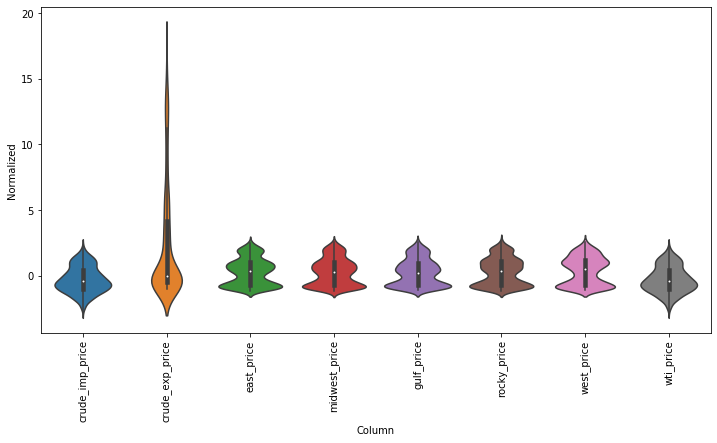

In [7]:
#View the distribution of the normalized data
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [8]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [9]:
w1= WindowGenerator(input_width=8, label_width=1, shift=1,
                     label_columns=['east_price'])
w1

Total window size: 9
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [8]
Label column name(s): ['east_price']

In [10]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [11]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)


print('The window is the entire window size. "3 batches,11 time-step windows, and 13 features"')
print(f'Window shape: {example_window.shape}')
print('--------------------------------')
print('The inputs shape defines the amount of "batches, time-step windows, and features" for the inputs')
print(f'Inputs shape: {example_inputs.shape}')
print('--------------------------------')
print('The labels shape defines the amount of "batches, time-step windows, and features" for the labels')

print(f'labels shape: {example_labels.shape}')

The window is the entire window size. "3 batches,11 time-step windows, and 13 features"
Window shape: (3, 9, 8)
--------------------------------
The inputs shape defines the amount of "batches, time-step windows, and features" for the inputs
Inputs shape: (3, 8, 8)
--------------------------------
The labels shape defines the amount of "batches, time-step windows, and features" for the labels
labels shape: (3, 1, 1)


In [12]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=30,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [13]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [14]:
# Each element is an (inputs, label) pair
w1.train.element_spec

(TensorSpec(shape=(None, 8, 8), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [15]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (30, 8, 8)
Labels shape (batch, time, features): (30, 1, 1)


## Recurrent Neural Network Model

In [16]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [17]:
print('Input shape:', w1.example[0].shape)
print('Output shape:', lstm_model(w1.example[0]).shape)

Input shape: (30, 8, 8)
Output shape: (30, 8, 1)


In [18]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [19]:
history = compile_and_fit(lstm_model, w1)

val_performance = {}
performance = {}

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(w1.val)
performance['LSTM'] = lstm_model.evaluate(w1.test, verbose=0)

10/10 [==============================] - 0s 5ms/step - loss: 0.1126 - mean_absolute_error: 0.2729


In [20]:
w1.train

<MapDataset shapes: ((None, 8, 8), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [21]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 32)             5248      
_________________________________________________________________
dense (Dense)                (None, 8, 1)              33        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [22]:
lstm_model.predict(w1.test)

array([[[0.74384624],
        [1.0169683 ],
        [1.1964053 ],
        ...,
        [1.3035065 ],
        [1.270141  ],
        [1.2950783 ]],

       [[0.45843458],
        [0.6111379 ],
        [0.69254804],
        ...,
        [0.7666869 ],
        [0.7897283 ],
        [0.7656976 ]],

       [[0.8359353 ],
        [1.040299  ],
        [1.1399596 ],
        ...,
        [1.3267883 ],
        [1.3579892 ],
        [1.3631772 ]],

       ...,

       [[0.60036373],
        [0.79764825],
        [0.9300824 ],
        ...,
        [1.097649  ],
        [1.1568394 ],
        [1.2385086 ]],

       [[0.7708094 ],
        [0.9295453 ],
        [0.989757  ],
        ...,
        [1.0328461 ],
        [0.9887082 ],
        [0.99136007]],

       [[0.89931077],
        [1.180834  ],
        [1.2984734 ],
        ...,
        [1.2661678 ],
        [1.357985  ],
        [1.3270315 ]]], dtype=float32)

In [23]:
for layer in lstm_model.layers:
    print(layer.weights)

[<tf.Variable 'lstm/lstm_cell/kernel:0' shape=(8, 128) dtype=float32, numpy=
array([[ 0.06317821,  0.00570595, -0.1256694 , ...,  0.03570895,
        -0.02335424,  0.10115358],
       [-0.04583039,  0.26118162, -0.19245866, ...,  0.15527175,
        -0.06106023, -0.09157041],
       [ 0.04052566,  0.06021512,  0.08206655, ...,  0.14169618,
        -0.11997489,  0.07902904],
       ...,
       [-0.20336393,  0.17584857,  0.02295608, ..., -0.08985679,
         0.07897615, -0.21639949],
       [ 0.09321486,  0.08986887,  0.0084048 , ...,  0.03297802,
         0.11198585, -0.23789756],
       [-0.18439333,  0.0934398 , -0.02386812, ...,  0.0089996 ,
        -0.06215607, -0.183803  ]], dtype=float32)>, <tf.Variable 'lstm/lstm_cell/recurrent_kernel:0' shape=(32, 128) dtype=float32, numpy=
array([[-0.05995413, -0.08177325,  0.00977294, ...,  0.18789442,
         0.0434801 ,  0.05337832],
       [ 0.02394366,  0.03067589, -0.18632019, ...,  0.09057114,
         0.2354452 ,  0.05265892],
      

In [24]:
import tensorflowjs as tjfs

tjfs.converters.save_keras_model(lstm_model, "../LSTM_model")


/Users/ryanngreen/anaconda3/lib/python3.7/site-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)
